## 호박 가격 책정을 위한 선형 및 다항 회귀 - 3강

필요한 라이브러리와 데이터셋을 로드합니다. 데이터를 다음 조건을 만족하는 데이터프레임으로 변환합니다:

- 부셸 단위로 가격이 매겨진 호박만 가져오기
- 날짜를 월로 변환하기
- 높은 가격과 낮은 가격의 평균으로 가격 계산하기
- 가격을 부셸 수량 기준으로 변환하기


In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('../../data/US-pumpkins.csv')
pumpkins.head()

City Name Type       Package      Variety Sub Variety  Grade     Date  \
0  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN  4/29/17   
1  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN   5/6/17   
2  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
3  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
4  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  11/5/16   

   Low Price  High Price  Mostly Low  ...  Unit of Sale Quality Condition  \
0      270.0       280.0       270.0  ...           NaN     NaN       NaN   
1      270.0       280.0       270.0  ...           NaN     NaN       NaN   
2      160.0       160.0       160.0  ...           NaN     NaN       NaN   
3      160.0       160.0       160.0  ...           NaN     NaN       NaN   
4       90.0       100.0        90.0  ...           NaN     NaN       NaN   

  Appearance Storage  Crop Repack  Trans Mode  Unnamed: 24  Unnamed: 25  
0        NaN     NaN   NaN      E         NaN          NaN          NaN  
1        NaN     NaN   NaN      E         NaN          NaN          NaN  
2        NaN     NaN   NaN      N         NaN          NaN          NaN  
3        NaN     NaN   NaN      N         NaN          NaN          NaN  
4        NaN     NaN   NaN      N         NaN          NaN          NaN  

[5 rows x 26 columns]

In [168]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

new_columns = ['Package', 'Variety', 'City Name', 'Month', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


Month  DayOfYear   Variety       City               Package  Low Price  \
70      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   
71      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
72     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
73     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       17.0   
74     10        281  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   

    High Price      Price  
70        15.0  13.636364  
71        18.0  16.363636  
72        18.0  16.363636  
73        17.0  15.454545  
74        15.0  13.636364

산점도는 우리가 8월부터 12월까지의 월별 데이터만 가지고 있음을 상기시켜줍니다. 선형적으로 결론을 내리기 위해서는 아마도 더 많은 데이터가 필요할 것입니다.


<AxesSubplot:xlabel='Month', ylabel='Price'>

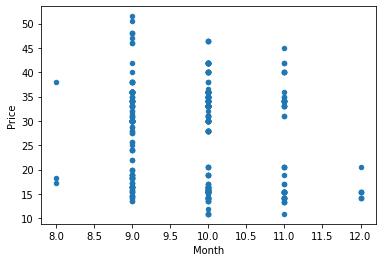

In [169]:
new_pumpkins.plot.scatter('Month','Price')

<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

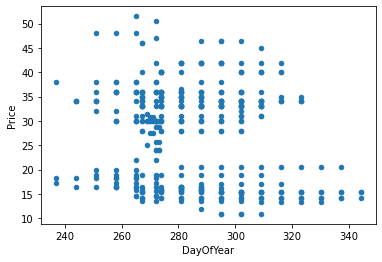

In [170]:
new_pumpkins.plot.scatter('DayOfYear','Price')

In [171]:
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

-0.14878293554077535
-0.16673322492745407


상관관계는 꽤 작아 보이지만, 더 중요한 다른 관계가 있는 것 같습니다. 위의 플롯에서 가격 지점들이 몇 가지 뚜렷한 클러스터를 형성하는 것처럼 보입니다. 이제 다양한 호박 품종을 보여주는 플롯을 만들어 봅시다:


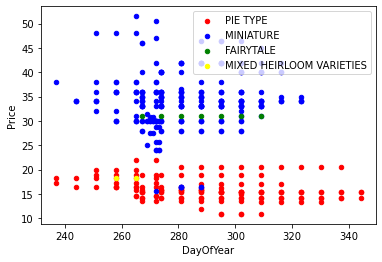

In [172]:
ax=None
colors = ['red','blue','green','yellow']
for i,var in enumerate(new_pumpkins['Variety'].unique()):
    ax = new_pumpkins[new_pumpkins['Variety']==var].plot.scatter('DayOfYear','Price',ax=ax,c=colors[i],label=var)

<AxesSubplot:xlabel='Variety'>

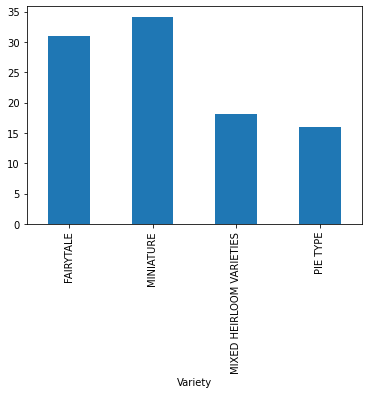

In [173]:
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')

-0.2669192282197318


<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

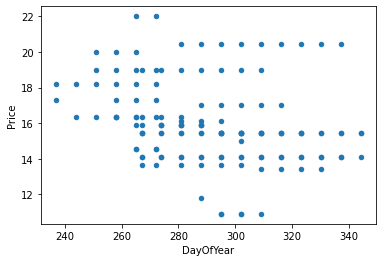

In [174]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='PIE TYPE']
print(pie_pumpkins['DayOfYear'].corr(pie_pumpkins['Price']))
pie_pumpkins.plot.scatter('DayOfYear','Price')

### 선형 회귀

우리는 Scikit Learn을 사용하여 선형 회귀 모델을 훈련할 것입니다:


In [175]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [176]:
X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')


Mean error: 2.77 (17.2%)


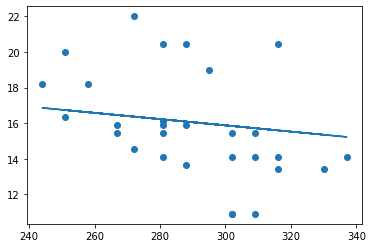

In [177]:
plt.scatter(X_test,y_test)
plt.plot(X_test,pred)

선형 회귀 계수로부터 직선의 기울기를 구할 수 있습니다:


In [178]:
lin_reg.coef_, lin_reg.intercept_

(array([-0.01751876]), 21.133734359909326)

In [179]:
# Pumpkin price on programmer's day

lin_reg.predict([[256]])

array([16.64893156])

### 다항 회귀

특성과 결과 간의 관계가 본질적으로 비선형일 때가 있습니다. 예를 들어, 호박 가격은 겨울(1월, 2월)에 높았다가 여름(5월~7월)에 떨어지고 다시 상승할 수 있습니다. 선형 회귀는 이러한 관계를 정확히 찾아내지 못할 수 있습니다.

이 경우 추가적인 특성을 고려할 수 있습니다. 간단한 방법은 입력 특성에서 다항식을 사용하는 것으로, 이를 통해 **다항 회귀**를 수행할 수 있습니다. Scikit Learn에서는 파이프라인을 사용하여 다항 특성을 자동으로 미리 계산할 수 있습니다.


Mean error: 2.73 (17.0%)
Model determination:  0.07639977655280217


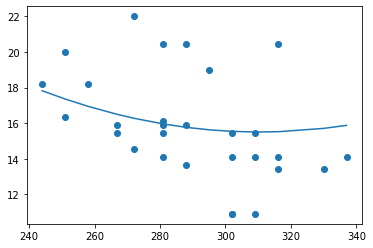

In [180]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

plt.scatter(X_test,y_test)
plt.plot(sorted(X_test),pipeline.predict(sorted(X_test)))

### 다양한 품종 인코딩

이상적인 상황에서는 동일한 모델을 사용하여 다양한 호박 품종의 가격을 예측할 수 있기를 원합니다. 품종을 고려하기 위해서는 먼저 이를 숫자 형태로 변환하거나 **인코딩**해야 합니다. 이를 수행하는 방법은 여러 가지가 있습니다:

* 간단한 숫자 인코딩은 다양한 품종의 테이블을 생성한 다음, 품종 이름을 해당 테이블의 인덱스로 대체하는 방식입니다. 하지만 선형 회귀에는 적합하지 않은 방법입니다. 왜냐하면 선형 회귀는 인덱스의 숫자 값을 고려하는데, 이 숫자 값이 가격과 수치적으로 상관관계가 없을 가능성이 높기 때문입니다.
* 원-핫 인코딩은 `Variety` 열을 4개의 다른 열로 대체하며, 각 품종에 대해 하나의 열을 생성합니다. 해당 행이 특정 품종에 속하면 1을, 그렇지 않으면 0을 포함합니다.

아래 코드는 품종을 원-핫 인코딩하는 방법을 보여줍니다:


In [181]:
pd.get_dummies(new_pumpkins['Variety'])

FAIRYTALE  MINIATURE  MIXED HEIRLOOM VARIETIES  PIE TYPE
70            0          0                         0         1
71            0          0                         0         1
72            0          0                         0         1
73            0          0                         0         1
74            0          0                         0         1
...         ...        ...                       ...       ...
1738          0          1                         0         0
1739          0          1                         0         0
1740          0          1                         0         0
1741          0          1                         0         0
1742          0          1                         0         0

[415 rows x 4 columns]

### 다양한 품종에 대한 선형 회귀

이제 위와 동일한 코드를 사용할 것이지만, `DayOfYear` 대신 원-핫 인코딩된 품종을 입력으로 사용하겠습니다:


In [182]:
X = pd.get_dummies(new_pumpkins['Variety'])
y = new_pumpkins['Price']

In [183]:
def run_linear_regression(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train,y_train)

    pred = lin_reg.predict(X_test)

    mse = np.sqrt(mean_squared_error(y_test,pred))
    print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

    score = lin_reg.score(X_train,y_train)
    print('Model determination: ', score)

run_linear_regression(X,y)

Mean error: 5.24 (19.7%)
Model determination:  0.774085281105197


우리는 또한 동일한 방식으로 다른 기능들을 사용해보고, `Month`나 `DayOfYear`와 같은 수치형 기능들과 결합할 수 있습니다:


In [184]:
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

run_linear_regression(X,y)

Mean error: 2.84 (10.5%)
Model determination:  0.9401096672643048


### 다항 회귀

다항 회귀는 원-핫 인코딩된 범주형 특성과 함께 사용할 수도 있습니다. 다항 회귀를 학습시키는 코드는 위에서 본 것과 본질적으로 동일합니다.


In [185]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 2.23 (8.25%)
Model determination:  0.9652870784724543



---

**면책 조항**:  
이 문서는 AI 번역 서비스 [Co-op Translator](https://github.com/Azure/co-op-translator)를 사용하여 번역되었습니다. 정확성을 위해 최선을 다하고 있으나, 자동 번역에는 오류나 부정확성이 포함될 수 있습니다. 원본 문서를 해당 언어로 작성된 상태에서 권위 있는 자료로 간주해야 합니다. 중요한 정보의 경우, 전문적인 인간 번역을 권장합니다. 이 번역 사용으로 인해 발생하는 오해나 잘못된 해석에 대해 당사는 책임을 지지 않습니다.  
